    Jacob Knopping
    4/23/2020
    
# Final Capstone: Image Classification of 10 Monkey Species


## 1.0 Introduction

The image dataset used in this capstone project can be found on Kaggle ([10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species)). Images from this dataset are 400 x 300 px or larger, in JPEG format (approximately 1400 images in total). This dataset consists of two folders: training, and validation. Each folder contains 10 subfolders, each corresponding to a different monkey species. They are labeled as follows:

    n0 = alouattapalliata 
    n1 = erythrocebuspatas
    n2 = cacajaocalvus 
    n3 = macacafuscata
    n4 = cebuellapygmea 
    n5 = cebuscapucinus
    n6 = micoargentatus 
    n7 = saimirisciureus
    n8 = aotusnigriceps 
    n9 = trachypithecusjohnii
    
The goal of this capstone project is to build a high-performance convolutional neural network (CNN) model for image classification of 10 monkey species. In order to accomplish this goal, multiple models will be trained and evaluated, including pre-trained neural network models. This [article from "Scientific Reports"](https://www.nature.com/articles/s41598-019-44565-w) helps explain how image classification models such as this can be invaluable for wildlife conservation efforts:

“Collecting animal imagery data with motion sensitive cameras is a minimally invasive approach to obtaining relative densities and estimating population trends in animals over time...However, due to their complexity, images are not readily analyzable in their raw form and relevant information must be visually extracted. Therefore, human labor is currently the primary means to recognize and count animals in images. This bottleneck impedes the progress of ecological studies that involve image processing...Deep-learning methods have revolutionized our ability to train digital computers to recognize all kinds of objects from imagery data including...wildlife species. [Deep learning/image recognition techniques] may significantly increase the efficiency of associated ecological studies.”

## 2.0 Exploring the Data

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import os
import cv2 
import tensorflow as tf
import keras
from skimage.io import imread
from skimage.transform import resize

# Components for model building
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.optimizers import Adam, SGD, Adadelta, RMSprop
from keras.models import Sequential, Model

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Backend
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Create directories to import the data
train_dir = 'C:\\Users\\Jacob Knopping\\Desktop\\Python Files\\Thinkful\\Thinkful_Capstone_Projects\\10-monkey-species\\training\\training'
test_dir = 'C:\\Users\\Jacob Knopping\\Desktop\\Python Files\\Thinkful\\Thinkful_Capstone_Projects\\10-monkey-species\\validation\\validation'
labels_file_dir = 'C:\\Users\\Jacob Knopping\\Desktop\\Python Files\\Thinkful\\Thinkful_Capstone_Projects\\10-monkey-species\\monkey_labels.txt'

Let's have a look at the .txt file as a dataframe, which should show the labels for each species, and their corresponding image counts for training and validation. We can also generate a bar plot to compare the sizes of each set of images.

In [3]:
labels = pd.read_csv(labels_file_dir, header=[0])
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


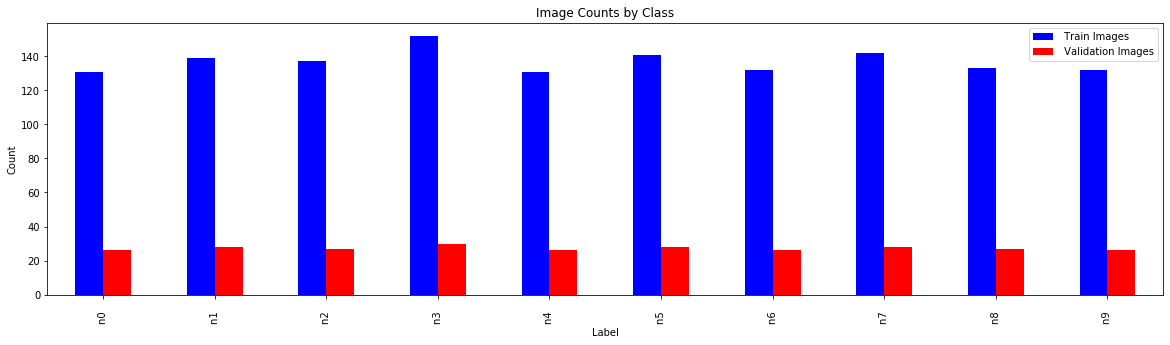

In [4]:
labels.plot(x='Label',
            y=[' Train Images ', ' Validation Images'],
            kind='bar',
            color=['b', 'r'],
            figsize=(20, 5))
plt.title('Image Counts by Class')
plt.ylabel('Count')
plt.show()

The amount of image data looks very similar across all species for both training and validation, and should not be an issue moving forward.

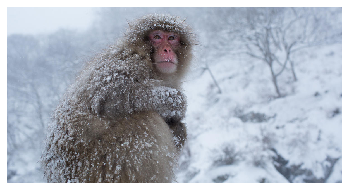

In [5]:
# Viewing a random image
img = imread(f'{train_dir}\\n3\\n3046.jpg')
plt.imshow(img)
plt.axis("Off")
plt.show()

Next, let's just get a sense for what some of the images look like, and how each monkey species compares to one another.

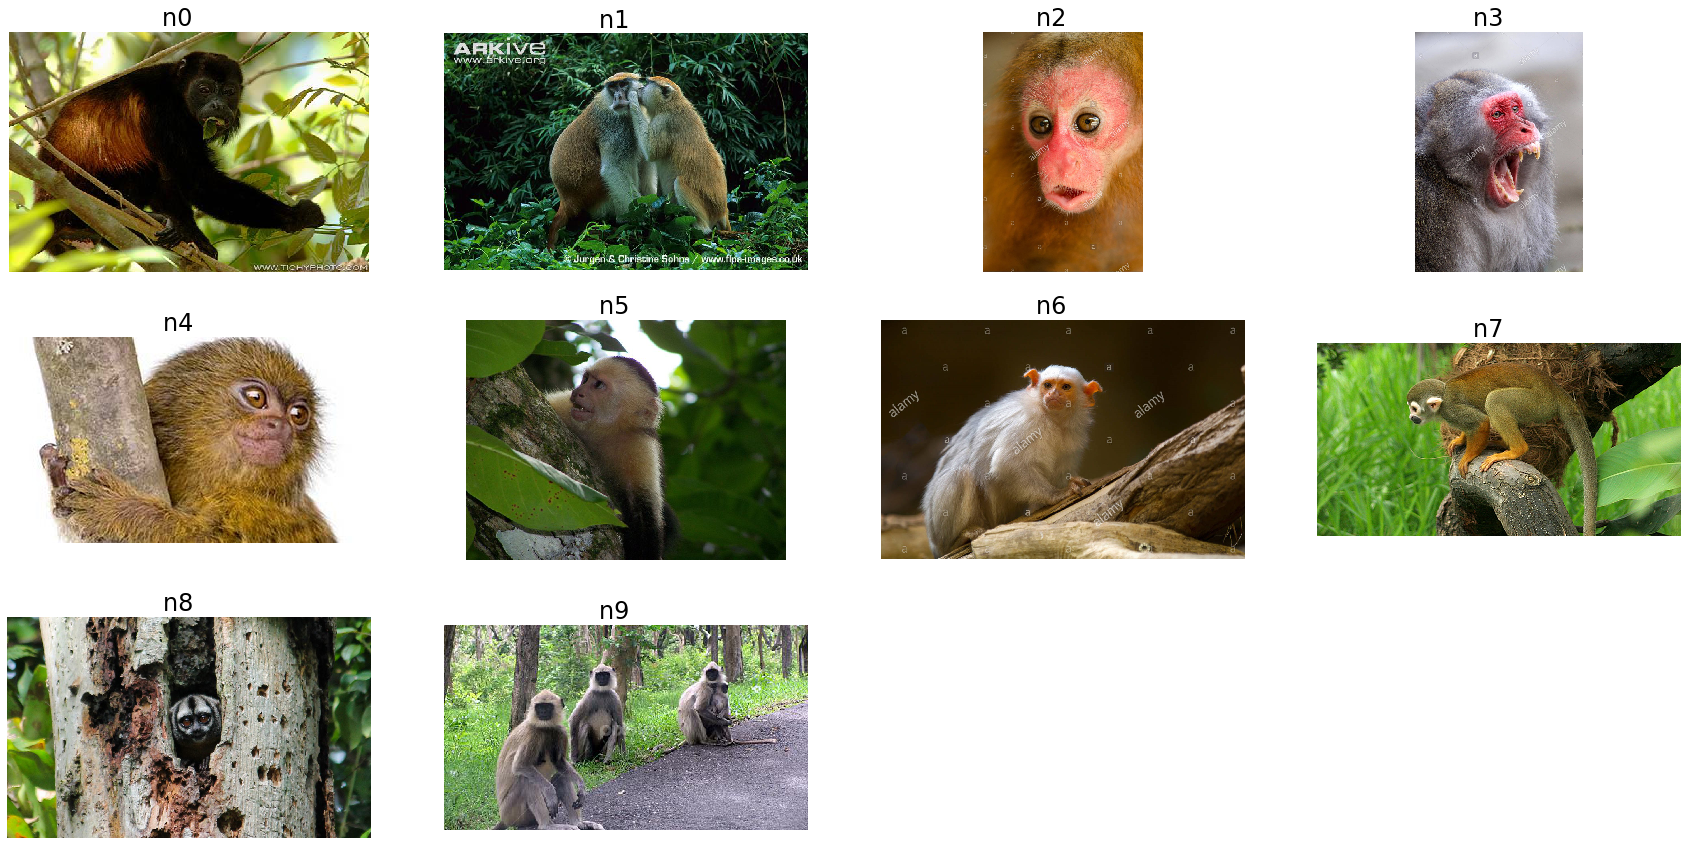

In [6]:
#Plot image for each class
def plots(img, figsize, rows, titles=None):
    fig = plt.figure(figsize=figsize)
    for i in range(len(img)):
        sp = fig.add_subplot(rows, len(img)//rows+1, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=24)
        plt.imshow(img[i])
        
images = []
for i in range(10):
    file = os.listdir(f'{train_dir}/n%d'%i)
    img = plt.imread(f'{train_dir}/n%d/{file[0]}'%i)
    images.append(img)

plots(images, figsize=(30,15), rows=3, titles=labels['Label'])

## 3.0 Image processing with Keras

Keras offers tools for image processing and data augmentation ([link to documentation](https://keras.io/preprocessing/image/)) that will allow us to generate training and validation data.

In [7]:
# Establish constants
img_size = 224
batch_size = 8

# Keras ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range = 90,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.75,1.0],
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(img_size, img_size),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## 4.0 Training CNN Models

Now it's time to start training CNN models, using the train_generator and validation_generator established above!

### 4.1 First CNN Model

The first CNN model will be built with simplicity in mind. This model will have less parameters, and will train much quicker than the subsequent pre-trained models. However, accuracy on the validation set is likely to be significantly lower, and more epochs will have to be run.

In [8]:
# CNN model
model  = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_size, img_size,3)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 64)      73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 128)      

The amount of parameters in this inital model would be impractical. Adding convolutional and max pooling layers will reduce the parameter size.

In [9]:
# CNN model
cnn_model  = Sequential()

cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(10, activation='softmax'))

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)       

Additonal convolutional and max pooling layers reduced the number of parameters significantly. Now we are ready to train the model.

In [10]:
# Compile
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

In [11]:
# Use Keras ModelCheckpoint to save the best model
filepath = 'cnn_monkey.weights.best.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callback_list = [checkpoint]

# Fit model
cnn_history = cnn_model.fit_generator(train_generator,
                                      epochs=150,
                                      verbose=1,
                                      #shuffle=True,
                                      callbacks=callback_list,
                                      validation_data=validation_generator)

Epoch 1/150
138/138 [==============================] - 89s 646ms/step - loss: 2.2975 - accuracy: 0.1293 - val_loss: 2.3845 - val_accuracy: 0.1691

Epoch 00001: val_accuracy improved from -inf to 0.16912, saving model to cnn_monkey.weights.best.hdf5
Epoch 2/150
138/138 [==============================] - 86s 623ms/step - loss: 2.1960 - accuracy: 0.1903 - val_loss: 2.2268 - val_accuracy: 0.1471

Epoch 00002: val_accuracy did not improve from 0.16912
Epoch 3/150
138/138 [==============================] - 87s 633ms/step - loss: 2.0769 - accuracy: 0.2477 - val_loss: 1.8520 - val_accuracy: 0.3382

Epoch 00003: val_accuracy improved from 0.16912 to 0.33824, saving model to cnn_monkey.weights.best.hdf5
Epoch 4/150
138/138 [==============================] - 99s 717ms/step - loss: 1.9652 - accuracy: 0.2823 - val_loss: 1.4298 - val_accuracy: 0.4265

Epoch 00004: val_accuracy improved from 0.33824 to 0.42647, saving model to cnn_monkey.weights.best.hdf5
Epoch 5/150
138/138 [========================

138/138 [==============================] - 91s 658ms/step - loss: 0.8267 - accuracy: 0.6995 - val_loss: 0.3897 - val_accuracy: 0.7169

Epoch 00076: val_accuracy did not improve from 0.72794
Epoch 77/150
138/138 [==============================] - 88s 641ms/step - loss: 0.9321 - accuracy: 0.6785 - val_loss: 0.3857 - val_accuracy: 0.7169

Epoch 00077: val_accuracy did not improve from 0.72794
Epoch 78/150
138/138 [==============================] - 90s 649ms/step - loss: 0.8597 - accuracy: 0.6995 - val_loss: 0.3407 - val_accuracy: 0.6875

Epoch 00078: val_accuracy did not improve from 0.72794
Epoch 79/150
138/138 [==============================] - 88s 636ms/step - loss: 0.8777 - accuracy: 0.6976 - val_loss: 0.5581 - val_accuracy: 0.7353

Epoch 00079: val_accuracy improved from 0.72794 to 0.73529, saving model to cnn_monkey.weights.best.hdf5
Epoch 80/150
138/138 [==============================] - 91s 661ms/step - loss: 0.8920 - accuracy: 0.6703 - val_loss: 0.5121 - val_accuracy: 0.7206

Epo

### 4.1.2 First CNN Model Evaluation

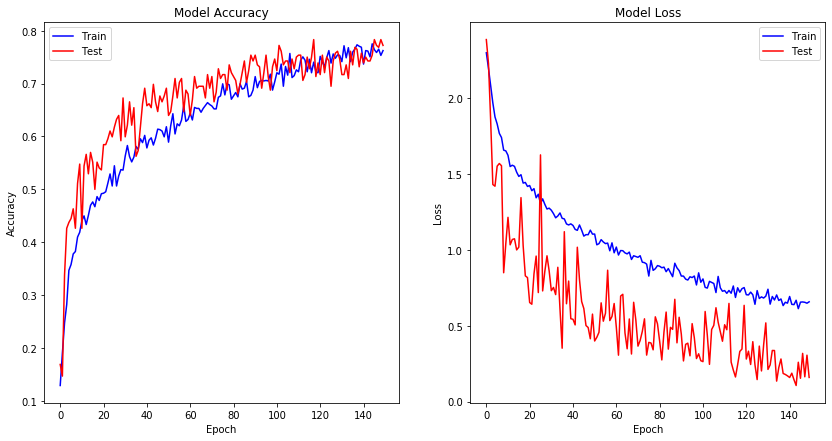

In [12]:
# Plot accuracy and loss to visualize model results

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], color='b')
plt.plot(cnn_history.history['val_accuracy'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], color='b')
plt.plot(cnn_history.history['val_loss'], color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.show()

Both model accuracy and model loss gradually improve over time, with a bit of variation from one epoch to the next. Accuracy and loss appear to have mostly plateaued. It's possible that with more epochs, accuracy could still be slightly improved beyond 78%, however, not significantly improved. If the subsequent models do not achieve more accurate results, then I will come back to this model and execute more epochs to achieve the highest accuracy possible. Given the time cost, and anticipated higher accuracy of pre-trained models, this will only be done if necessary.

In [13]:
# Load weights from the best model, and apply model structure
cnn_model  = Sequential()
cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(128, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(10, activation='softmax'))

# Load weights
cnn_model.load_weights('cnn_monkey.weights.best.hdf5')

In [14]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


Now that weights from the model with the best performance (using accuracy as the metric) are loaded into the model, we can evaluate the final performance of the model. To do this, we will get statistical measures for test loss and test accuracy, as well as look at a confusion matrix and classification report.

In [15]:
# Evaluation scores
scores = cnn_model.evaluate(validation_generator, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.3301616907119751
Test accuracy: 0.783088207244873


In [16]:
# Import confusion_matrix, classification_report from Sci-kit learn
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Make predictions
predictions = cnn_model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
#predicted_classes

In [18]:
y_true = validation_generator.classes
#y_true

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, predicted_classes)
cm

array([[15,  0,  1,  0,  0,  0,  0,  0,  2,  8],
       [ 0, 20,  0,  0,  2,  0,  0,  2,  2,  2],
       [ 0,  0, 25,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  2,  0, 26,  0,  1,  0,  0,  0,  1],
       [ 1,  0,  0,  2, 20,  0,  0,  1,  2,  0],
       [ 2,  1,  0,  1,  0, 17,  2,  0,  2,  3],
       [ 0,  2,  0,  0,  0,  2, 22,  0,  0,  0],
       [ 0,  3,  0,  0,  3,  0,  0, 21,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  2, 24,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0, 23]], dtype=int64)

In [20]:
# Classification report
class_labels = list(validation_generator.class_indices.keys()) 
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

          n0       0.71      0.58      0.64        26
          n1       0.69      0.71      0.70        28
          n2       0.96      0.93      0.94        27
          n3       0.90      0.87      0.88        30
          n4       0.77      0.77      0.77        26
          n5       0.85      0.61      0.71        28
          n6       0.92      0.85      0.88        26
          n7       0.81      0.75      0.78        28
          n8       0.71      0.89      0.79        27
          n9       0.62      0.88      0.73        26

    accuracy                           0.78       272
   macro avg       0.79      0.78      0.78       272
weighted avg       0.79      0.78      0.78       272



As seen in the confuson matrix, the most common error was predicting class 'n9' when the true label was 'n0', which occured 8 times. This, along with 3 other false negatives, yielded a low recall score of 0.58. Overall, the classification report shows that errors were not evenly distributed; the model predicted some classes better than others. Considering the number of classes, this model does a decent job. However, these results are not ultimately satisfactory. Perhaps using pre-trained models will achieve stronger results.

### 4.2 Xception model

Keras Applications ([link](https://keras.io/applications/)) offers pre-trained deep learning models, which have been known for high performance. The first model we will be using, with weights trained on ImageNet, is Xception. Xception is one of the top performing models on the ImageNet validation dataset, and also has a low amount of parameters in comparison to other similar models. Thus, I have selected it as the pre-trained model to begin with.

In [21]:
from keras import applications

# Xception CNN classifier
base_model_Xception = applications.Xception(weights='imagenet', # use pre-trained weights
                                           include_top=False # not including fully connected layers
                                           )
# Pooling layer
x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)

# Dropout layer
x = Dropout(0.4)(x)

# Classification layer for output (fully-connected)
predictions = Dense(10, activation='softmax')(x)

# Create full network for training
Xception_model = Model(inputs=base_model_Xception.input,
                             outputs=predictions)

Xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [22]:
# Compile
Xception_model.compile(loss='categorical_crossentropy',
                      optimizer=SGD(lr=.0001, momentum=0.9),
                       metrics=['accuracy'])

In [23]:
# Use Keras ModelCheckpoint to save the best model
filepath_2 = 'Xcpetion_monkey.weights.best.hdf5'
checkpoint_2 = keras.callbacks.ModelCheckpoint(filepath_2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callback_list_2 = [checkpoint_2]

Xception_history = Xception_model.fit_generator(train_generator,
                                                epochs=40,
                                                verbose=1,
                                                callbacks = callback_list_2,
                                                validation_data=validation_generator)

Epoch 1/40
138/138 [==============================] - 606s 4s/step - loss: 2.2894 - accuracy: 0.1366 - val_loss: 2.4654 - val_accuracy: 0.2978

Epoch 00001: val_accuracy improved from -inf to 0.29779, saving model to Xcpetion_monkey.weights.best.hdf5
Epoch 2/40
138/138 [==============================] - 600s 4s/step - loss: 2.2260 - accuracy: 0.1931 - val_loss: 2.2280 - val_accuracy: 0.4559

Epoch 00002: val_accuracy improved from 0.29779 to 0.45588, saving model to Xcpetion_monkey.weights.best.hdf5
Epoch 3/40
138/138 [==============================] - 600s 4s/step - loss: 2.1560 - accuracy: 0.2741 - val_loss: 2.1229 - val_accuracy: 0.5846

Epoch 00003: val_accuracy improved from 0.45588 to 0.58456, saving model to Xcpetion_monkey.weights.best.hdf5
Epoch 4/40
138/138 [==============================] - 600s 4s/step - loss: 2.0546 - accuracy: 0.3406 - val_loss: 2.0289 - val_accuracy: 0.6838

Epoch 00004: val_accuracy improved from 0.58456 to 0.68382, saving model to Xcpetion_monkey.weigh

### 4.2.2 Xception Model Evaluation

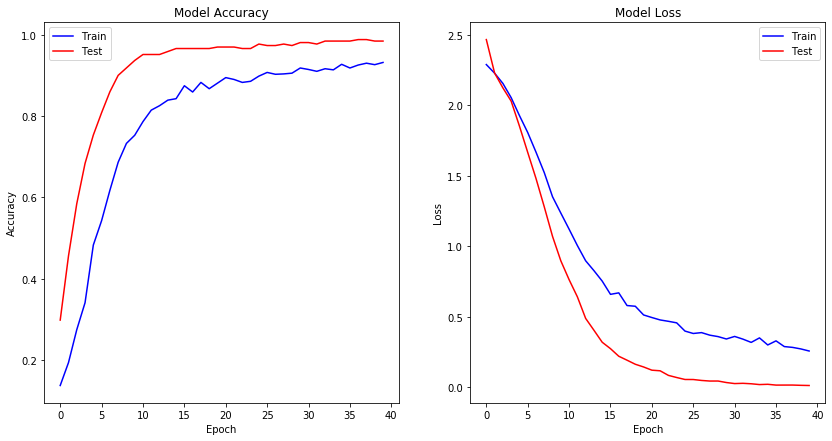

In [24]:
# Plot accuracy and loss to visualize model results

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(Xception_history.history['accuracy'], color='b')
plt.plot(Xception_history.history['val_accuracy'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,2,2)
plt.plot(Xception_history.history['loss'], color='b')
plt.plot(Xception_history.history['val_loss'], color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.show()

Model accuracy appears to be much higher with the Xception model, coming in at approximately 99% accuracy on the validation, or test, data. Accuracy and loss have reached a plateau, more or less. Again, there is a limitaion on time given how long it takes to train a model using a CPU (as opposed to running this on a GPU), but more epochs could be theoretically be performed. It's interesting to note that the training data has a slightly lower accuracy than the test data. Testing this model on other datasets be an area for further exploration outside this project for this reason. For now, overfitting certaintly is not an issue.

In [25]:
# Load weights from the best model, and apply model structure
base_model_Xception = applications.Xception(weights='imagenet', # use pre-trained weights
                                           include_top=False # not including fully connected layers
                                           )
x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(10, activation='softmax')(x)
Xception_model = Model(inputs=base_model_Xception.input, outputs=predictions)

# Load weights
Xception_model.load_weights('Xcpetion_monkey.weights.best.hdf5')

In [26]:
# Compile
Xception_model.compile(loss='categorical_crossentropy',
                       optimizer=SGD(lr=.0001, momentum=0.9),
                       metrics=['accuracy'])

Again, weights from the model with the best performance are loaded into the model, and we can evaluate the final performance of the model.

In [27]:
# Evaluation scores
scores = Xception_model.evaluate(validation_generator, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.014329766854643822
Test accuracy: 0.9889705777168274


In [28]:
# Confusion matrix
predictions = Xception_model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true=y_true, y_pred=predicted_classes)
cm

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 25,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 26,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 26]], dtype=int64)

In [29]:
# Classification report
class_labels = list(validation_generator.class_indices.keys()) 
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

          n0       1.00      1.00      1.00        26
          n1       1.00      0.96      0.98        28
          n2       1.00      1.00      1.00        27
          n3       1.00      1.00      1.00        30
          n4       1.00      1.00      1.00        26
          n5       0.97      1.00      0.98        28
          n6       1.00      0.96      0.98        26
          n7       0.97      1.00      0.98        28
          n8       1.00      0.96      0.98        27
          n9       0.96      1.00      0.98        26

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.99       272
weighted avg       0.99      0.99      0.99       272



Looking at the confusion matrix and classification report, the accuracy of this model really stands out. There are only three mislabled classes out of 272 in the validation data, and those errors are across three seperate classes. In other words, there is not one class that is predicted with a lower recall or precision than the others, in the three instances of a mislabeled class.

### 4.3 InceptionResNetV2 Model

Another pre-training deep learning model from Keras Applications is InceptionResNetV2. This model has slightly higher performance on ImageNet than Xception, although with a greater number of parameters (still significantly less than others). We will build train this model for comparison, and see if one model appears to offer a better solution than the other.

In [30]:
# InceptionResNetV2 CNN classifier
#from keras import applications

base_model_resNet = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False)

# Pooling layer
x = base_model_resNet.output
x = GlobalAveragePooling2D()(x)

#Dropout layer
x = Dropout(0.4)(x)

# Classification layer for output (fully-connected)
predictions = Dense(10, activation='softmax')(x)

# Create full network for training
resNet_model = Model(inputs=base_model_resNet.input,
                    outputs=predictions)

resNet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

conv2d_210 (Conv2D)             (None, None, None, 2 129024      activation_189[0][0]             
__________________________________________________________________________________________________
batch_normalization_198 (BatchN (None, None, None, 2 672         conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_190 (Activation)     (None, None, None, 2 0           batch_normalization_198[0][0]    
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, None, None, 1 399360      block8_6_ac[0][0]                
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, None, None, 2 172032      activation_190[0][0]             
__________________________________________________________________________________________________
batch_norm

In [31]:
# Compile
resNet_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(lr=.0001, momentum=0.9),
                     metrics=['accuracy'])

In [32]:
# Use Keras ModelCheckpoint to save the best model
filepath_3 = 'resNet_monkey.weights.best.hdf5'
checkpoint_3 = keras.callbacks.ModelCheckpoint(filepath_3, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1)
callback_list_3 = [checkpoint_3]

resNet_history = resNet_model.fit_generator(train_generator,
                                            epochs=40,
                                            verbose=1,
                                            callbacks = callback_list_3,
                                            validation_data=validation_generator)

Epoch 1/40
138/138 [==============================] - 1134s 8s/step - loss: 2.2672 - accuracy: 0.1703 - val_loss: 2.1175 - val_accuracy: 0.5368

Epoch 00001: val_accuracy improved from -inf to 0.53676, saving model to resNet_monkey.weights.best.hdf5
Epoch 2/40
138/138 [==============================] - 1032s 7s/step - loss: 1.9667 - accuracy: 0.3607 - val_loss: 1.7228 - val_accuracy: 0.7757

Epoch 00002: val_accuracy improved from 0.53676 to 0.77574, saving model to resNet_monkey.weights.best.hdf5
Epoch 3/40
138/138 [==============================] - 1027s 7s/step - loss: 1.6605 - accuracy: 0.5264 - val_loss: 1.3814 - val_accuracy: 0.8640

Epoch 00003: val_accuracy improved from 0.77574 to 0.86397, saving model to resNet_monkey.weights.best.hdf5
Epoch 4/40
138/138 [==============================] - 1044s 8s/step - loss: 1.3232 - accuracy: 0.6676 - val_loss: 1.0816 - val_accuracy: 0.9081

Epoch 00004: val_accuracy improved from 0.86397 to 0.90809, saving model to resNet_monkey.weights.b

### 4.3.2 InceptionResNetV2 Model Evaluation

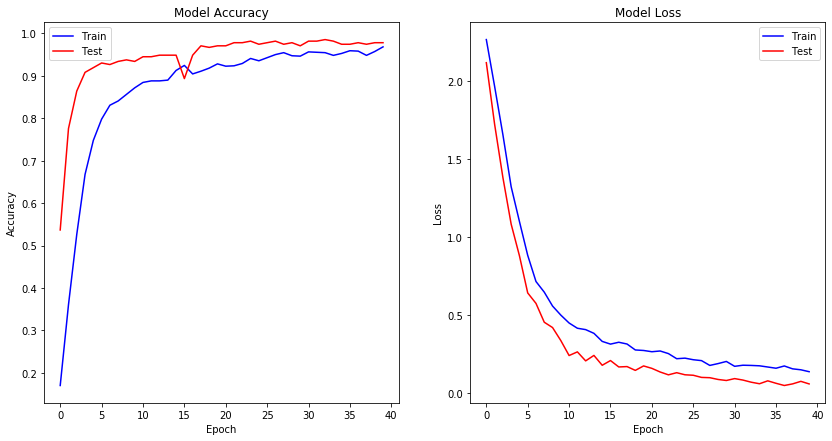

In [33]:
# Plot accuracy and loss to visualize model results

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(resNet_history.history['accuracy'], color='b')
plt.plot(resNet_history.history['val_accuracy'], color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,2,2)
plt.plot(resNet_history.history['loss'], color='b')
plt.plot(resNet_history.history['val_loss'], color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

plt.show()

Again, the number of epochs seems to appropriate, as accuracy and loss appear to have plateaud. Model accuracy is on par with the Xception model, also reaching an accuracy of 99% on the validation data. Again, the accuracy on the validation data is slightly higher than on the training data, but this margin is reduced in this InceptionResNet model. 

In [34]:
# Load weights from the best model, and apply model structure
base_model_resNet = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False)
x = base_model_resNet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(10, activation='softmax')(x)
resNet_model = Model(inputs=base_model_resNet.input,
                    outputs=predictions)
#Load weights
resNet_model.load_weights('resNet_monkey.weights.best.hdf5')

In [35]:
# Compile
resNet_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(lr=.0001, momentum=0.9),
                     metrics=['accuracy'])

Again, weights from the model with the best performance are loaded into the model above; we can evaluate the final performance of the model.

In [36]:
# Evaluation scores
scores = resNet_model.evaluate(validation_generator, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.06752534955739975
Test accuracy: 0.9852941036224365


In [37]:
# Conusion matrix
predictions = resNet_model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true=y_true, y_pred=predicted_classes)
cm

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 25,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 26,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 25]], dtype=int64)

In [38]:
# Classification report
class_labels = list(validation_generator.class_indices.keys()) 
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

          n0       0.93      1.00      0.96        26
          n1       1.00      1.00      1.00        28
          n2       1.00      1.00      1.00        27
          n3       1.00      1.00      1.00        30
          n4       1.00      0.96      0.98        26
          n5       1.00      1.00      1.00        28
          n6       0.96      1.00      0.98        26
          n7       1.00      0.93      0.96        28
          n8       0.96      1.00      0.98        27
          n9       1.00      0.96      0.98        26

    accuracy                           0.99       272
   macro avg       0.99      0.99      0.98       272
weighted avg       0.99      0.99      0.99       272



As with the Xception model, accuracy immediately stands out. There are only four instances of a mislabeled class. Class 'n7' was mislabeled as 'n6' and 'n8', hence a recall score of 0.93. Likewise, there were two false positives for class 'n0' ('n4', 'n9'), yielding a precision score of 0.93. Overall, the Xception model had was very marginally more accurate (269/272 versus 268/272), and its errors did not occur more than once within the same class.

## 5.0 Conclusion

As stated in the introduction, the goal of this capstone project was to build a high-performance convolutional neural network (CNN) model for image classification of 10 monkey species. Both the Xception model and InceptionResNet model accomplished this task, with 99% accuracy on the validation data. Using these pre-trained models from Keras Applications proved to make a very significant improvement, compared to the other CNN model (78% accuracy). The Xception model had marginally higher accuracy than the InceptionResNet, but this difference is more or less neglible. However, the InceptionResNet model did have slightly higher accuracy on the training data than the Xception model (~97% compared to 93%). Examining which model performs better on another dataset of the same monkey species, and whether or not this difference has any signficance, would be area for future work.